In [1]:
import numpy as np, xarray as xr, pandas as pd, pandas as pd, math, time, os # For data handling
import cartopy.crs as ccrs, matplotlib.pyplot as plt, matplotlib as mpl  # For plotting
from utils import *                                                      # Helper functions
import dask.array as da                                                  # For faster computations
from dask.diagnostics import ProgressBar                                 # For computation feedback
from dask.distributed import Client, LocalCluster                        # For parallelization
from datetime import datetime                                            # For calender handling
import s3fs                                                              # For reading bucket data
from ipywidgets import interact, interactive, fixed, widgets             # For interactive plotting
import statsmodels.formula.api as sm                                     # For regression
%load_ext autoreload
%autoreload 2                                                            # To auto-reload modules

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD",                       # Key to bucket
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

### Parallel cluster setup

In [13]:
client.close()

In [2]:
cluster = LocalCluster(n_workers=8, memory_limit='32GB') #16 is best (matches number of cores)
client = Client(cluster)

# Temperature

In [ ]:
tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorophyll

## Observations

In [2]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc')) # Monthly satellite observation of Chlorophyll

In [13]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

## Get data

In [2]:
path_to_folder = '/nird/projects/NS9252K/ada_escience/CLIPPED_files/'

In [3]:
with ProgressBar():
    chlosCesmHist = consistent_naming(xr.open_dataset(path_to_folder + 'chlos_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc'))
    chlosCesmHist = chlosCesmHist.isel(time=slice(0, -1)) #LAST DAY IS BAD
    chlosCesmHist = clip_to_region(chlosCesmHist, minlat=75, minlon=20, maxlon=60, maxlat=80)

/nird/home/sldam/miniconda3/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'chlos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
with ProgressBar():
    chlosNoresmHist = consistent_naming(xr.open_dataset(path_to_folder + 'chlos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc'))
    chlosNoresmHist = clip_to_region(chlosNoresmHist, minlat=75, maxlat=80, minlon=20, maxlon=60)

#### Anomalies

In [6]:
chlosCesmAnomaly = time_anomaly(chlosCesmHist, 0, 365*30, -365*30, -1)

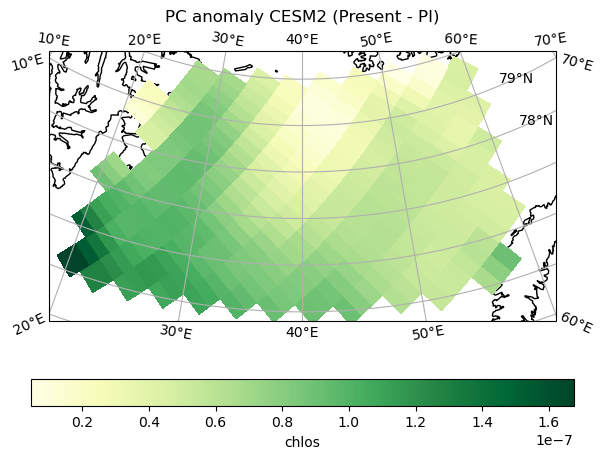

In [9]:
chlosCesmAnomaly.chlos.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='lon', y='lat', 
                   cmap='YlGn', cbar_kwargs={'location': 'bottom'})
plt.title('PC anomaly CESM2 (Present - PI)')
plt.show()

### Peaks

In [61]:
chlosCesmHistPeaks = find_peak_dates(chlosCesmHist.chlos)

/nird/home/sldam/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_58774/1274956957.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


In [62]:
chlosNoresmHistPeaks = find_peak_dates(chlosNoresmHist.chlos)

/nird/home/sldam/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tmp/ipykernel_58774/1274956957.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


In [13]:
chlosCesmHistPeaksAnomaly = time_anomaly(chlosCesmHistPeaks, 0, 30, -30, -1)

In [13]:
fig, axs = barentsMap(minlat=74, ncols=2)
chlosCesmHistPeaksAnomaly.plot(ax=barentsMap(minlat=74)[1], x='longitude', y='latitude', transform=ccrs.PlateCarree(), 
                            cmap='YlGn_r', levels=np.arange(-20, 0), cbar_kwargs={'location':'bottom', 'label':'Peak bloom DOY (difference)'})
plt.title('PBD Anomaly CESM2 (Present - PI)')
plt.show()

AttributeError: 'Figure' object has no property 'projection'

In [80]:
chlosCesmHistPeaksMean = regional_average(chlosCesmHistPeaks, model='CESM2', clip_coords=[20, 60, 75, 80]).squeeze()
chlosNoresmHistPeaksMean = regional_average(chlosNoresmHistPeaks, model='NorESM2-LM', clip_coords=[20, 60, 75, 80]).squeeze()

Found local areacello NetCDF
Found local areacello NetCDF


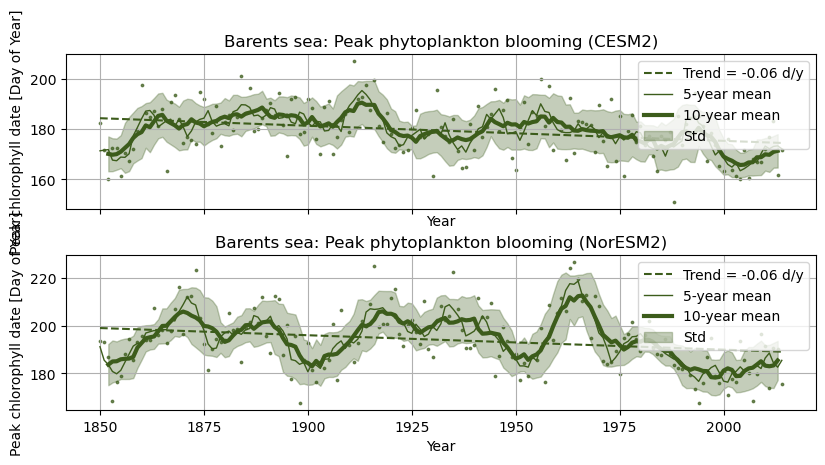

In [85]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)
regALLcesm = scatter_dates(chlosCesmHistPeaksMean, last_n_years=0, ax=axs[0], reg_summary=True, source='CESM2', color='#3C5C1B', anomaly=False)
regALLnoresm = scatter_dates(chlosNoresmHistPeaksMean, last_n_years=0, ax=axs[1], reg_summary=True, source='NorESM2', color='#3C5C1B', anomaly=False)
plt.subplots_adjust(left=0.1, bottom=0.06, top=0.95, right=0.85, wspace=0.30, hspace=0.3) 

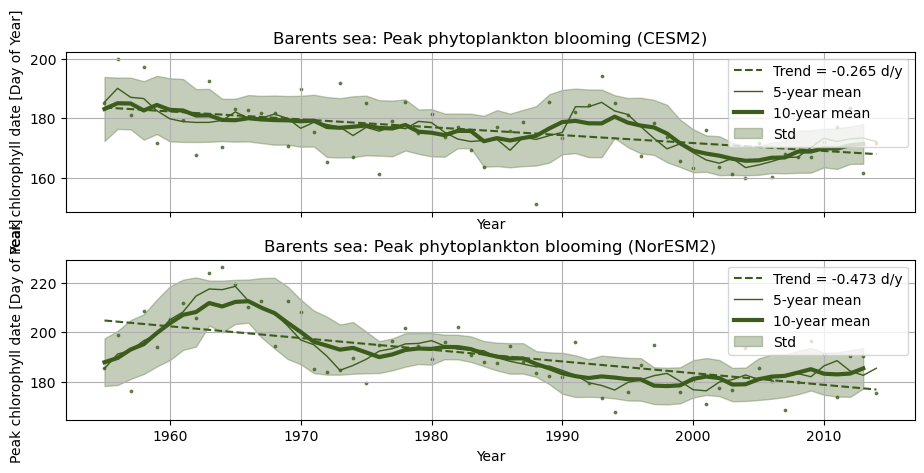

In [86]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)
reg60cesm = scatter_dates(chlosCesmHistPeaksMean, last_n_years=60, ax=axs[0], reg_summary=True, source='CESM2', color='#3C5C1B', anomaly=False)
reg60noresm = scatter_dates(chlosNoresmHistPeaksMean, last_n_years=60, ax=axs[1], reg_summary=True, source='NorESM2', color='#3C5C1B', anomaly=False)
plt.subplots_adjust(left=0.001, bottom=0.06, top=0.98, right=0.85, wspace=0.25, hspace=0.3) 

## NorESM2-LM

### Get data

In [24]:
os.listdir(path_to_folder)

['tos_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'tos_clipped_Oday_CESM2_1pctCO2_r1i1p1f1_gn_01010102-01510101.nc',
 'areacello_clipped_Ofx_CESM2_piControl_r1i1p1f1_gn.nc',
 'chlos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'tos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'siconc_clipped_SIday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'chlos_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'chlos_clipped_Oday_CESM2_1pctCO2_r1i1p1f1_gn_01010102-01510101.nc',
 'omldamax_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'omldamax_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc',
 'siconc_clipped_SIday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc']

In [22]:
chlosNoresm = xr.open_dataset(path_to_folder + 'chlos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc')

In [23]:
SINoresm = xr.open_dataset(path_to_folder + 'siconc_clipped_SIday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc')

In [24]:
chlosNoresm = clip_to_region(chlosNoresm, minlat=75, maxlat=80, minlon=20, maxlon=60)

In [25]:
SINoresm = clip_to_region(SINoresm, minlat=75, maxlat=80, minlon=20, maxlon=60)

### Sliders

In [11]:
slider_map(chlosNoresm.chlos, freq='D', start=datetime(2013, 4, 1), stop=datetime(2014, 10, 1), 
           name='PC NorESM2-LM', model=True, minlat=74)

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-04-01'…

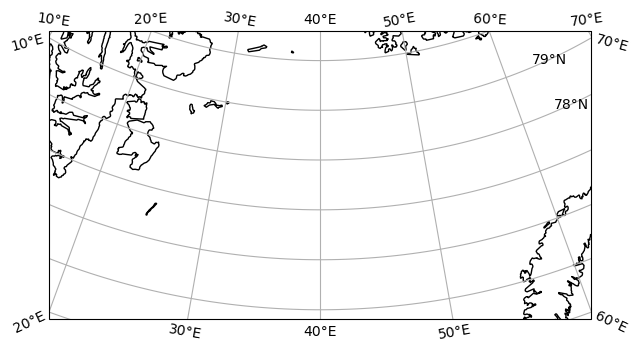

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-01', T…

In [14]:
slider_map(SINoresm.siconc, freq='M', start=datetime(2013, 1, 1), stop=datetime(2014, 12, 1), minlat=74, 
           name='SIC NorESM2-LM', model=True, color='Blues', levels=np.linspace(0, 100, 21))

### Anomalies

In [16]:
chlosNoresmAnomaly = time_anomaly(chlosNoresm, 0, 365*30, -365*30, -1)
SINoresmAnomaly = time_anomaly(SINoresm, 0, 365*30, -365*30, -1)

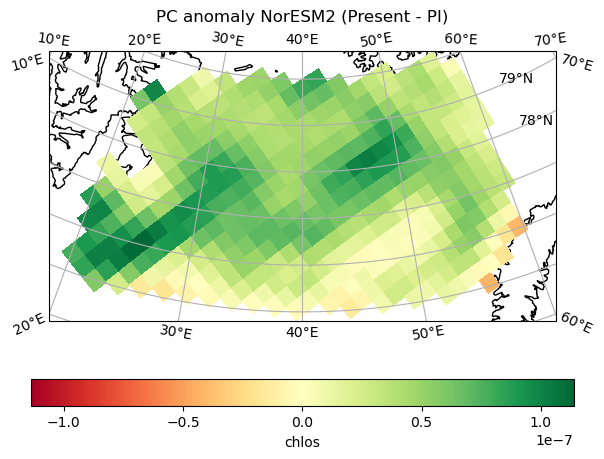

In [18]:
chlosNoresmAnomaly.chlos.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                   cmap='RdYlGn', cbar_kwargs={'location': 'bottom'})
plt.title('PC anomaly NorESM2 (Present - PI)')
plt.show()

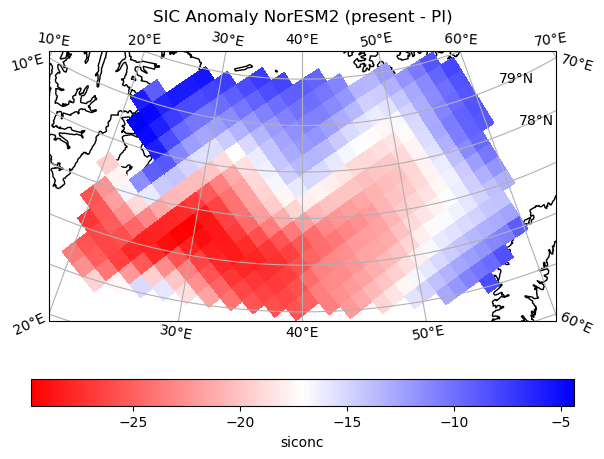

In [19]:
SINoresmAnomaly.siconc.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                        cmap='bwr_r', cbar_kwargs={'location': 'bottom'})
plt.title('SIC Anomaly NorESM2 (present - PI)')
plt.show()

### Peaks

In [26]:
chlosNoresmPeaks = find_peak_dates(chlosNoresm.chlos)

/nird/home/sldam/miniconda3/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/tos-project2/NS9600K/brittsc/WRF_output_Stian/FROM_TJERNO/utils.py:222: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


AttributeError: 'DataArray' object has no attribute 'lon'

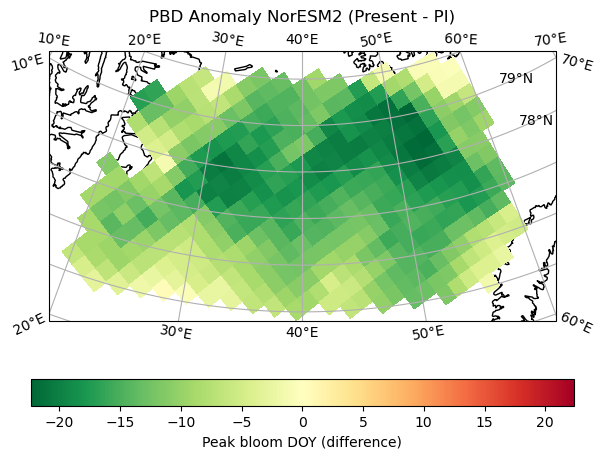

In [60]:
chlosNoresmPeaksAnomaly = time_anomaly(chlosNoresmPeaks, 0, 30, -30, -1)
chlosNoresmPeaksAnomaly.plot(ax=barentsMap(minlat=74)[1], x='longitude', y='latitude', transform=ccrs.PlateCarree(), 
                            cmap='RdYlGn_r', cbar_kwargs={'location':'bottom', 'label':'Peak bloom DOY (difference)'})
plt.title('PBD Anomaly NorESM2 (Present - PI)')
plt.show()

##### Whole Barents Mean

In [154]:
chlosNoresmPeaksMean = regional_average(chlosNoresmPeaks, model='NorESM2-LM', clip_coords=[20, 60, 75, 80]).squeeze()

Found local areacello NetCDF


<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7fe6dc21ef70>>


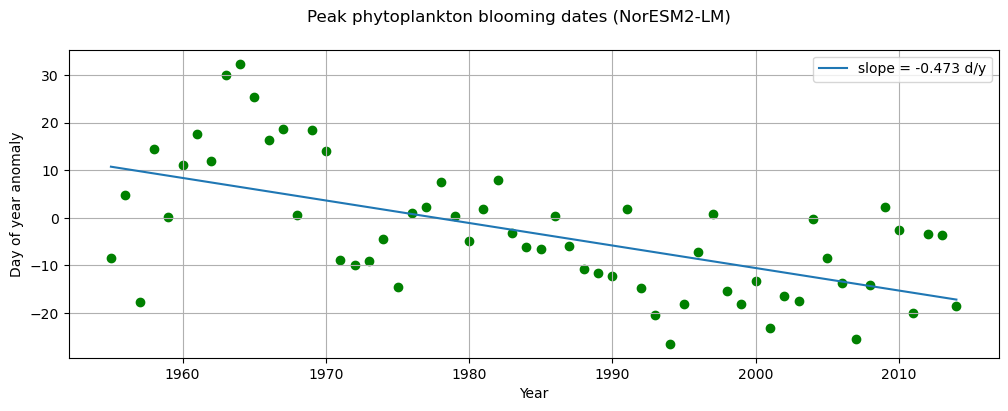

In [165]:
reg = scatter_dates(chlosNoresmPeaksMean, last_n_years=60, reg_summary=True)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7fe6dc196f10>>


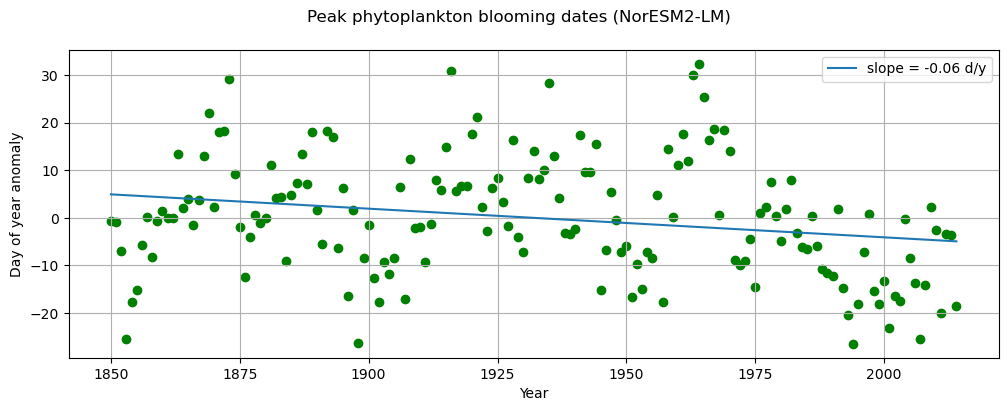

In [167]:
reg = scatter_dates(chlosNoresmPeaksMean, last_n_years=0, reg_summary=True)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7ff93eae6f70>>


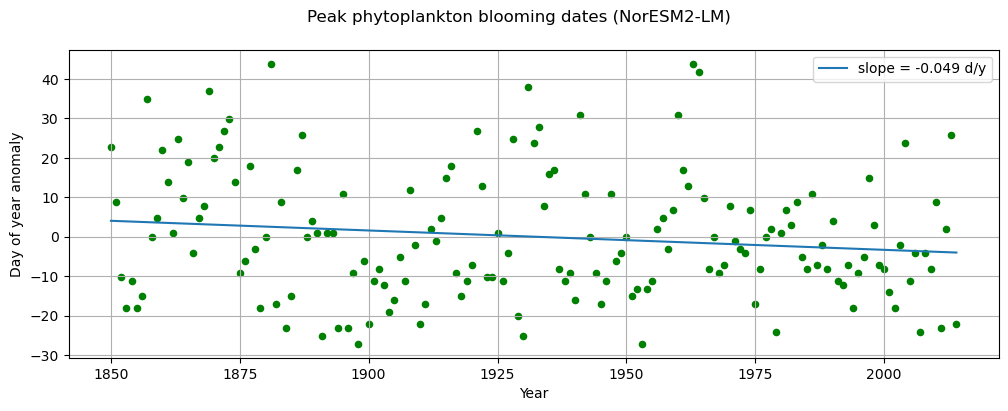

In [213]:
scatter_dates(peak_dates, last_n_years=0)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7ff957967130>>


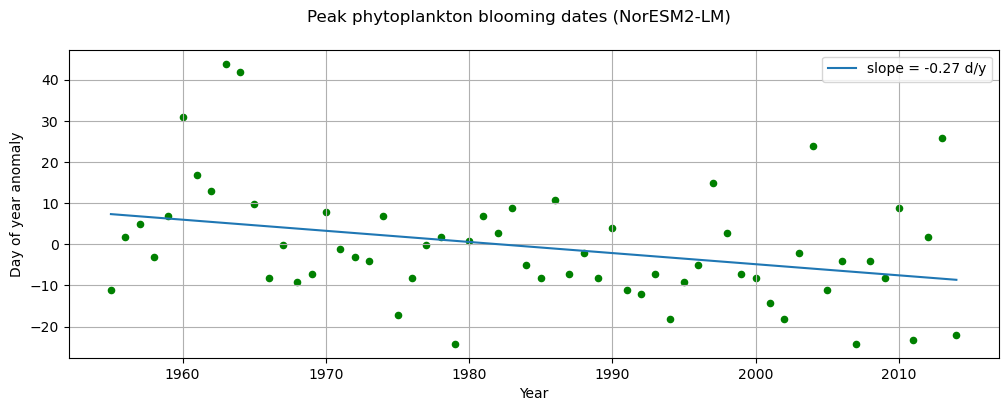

In [212]:
scatter_dates(peak_dates, last_n_years=60)

### Dependence on Sea Ice Concentration

In [97]:
SI_yearly_mean = SI_barents_mean.groupby('time.year').mean(dim='time')

df = pd.DataFrame([SI_yearly_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158d723d00>>


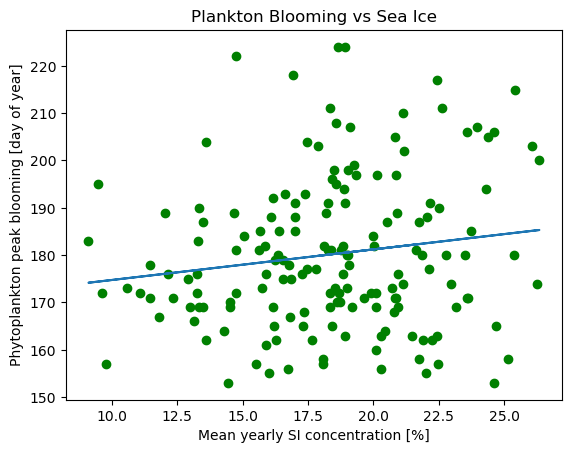

In [109]:
plt.xlabel('Mean yearly SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_yearly_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_yearly_mean.values, a * SI_yearly_mean.values + b)

In [96]:
SI_june_mean = SI_barents_mean.groupby('time.month')[5]
df = pd.DataFrame([SI_june_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158be8f580>>


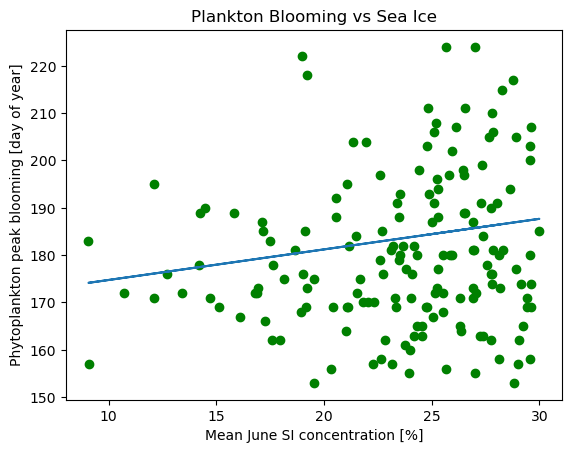

In [108]:
plt.xlabel('Mean June SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_june_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_june_mean.values, a * SI_march_mean.values + b)

### All years visualized

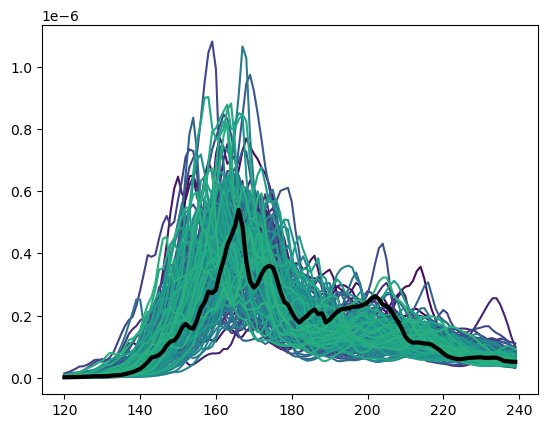

In [89]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::int(cmap.N/165)]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(1850, 2015)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

chlos_daily_mean_grouped = chlos_daily_mean.chlos.groupby('time.year')
[ax.plot(np.arange(120, 120+30*4), chlos_daily_mean_grouped[year].isel(time=slice(120, 120+30*4)), color=cmaplist[year-1850]) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), chlos_daily_mean.chlos.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


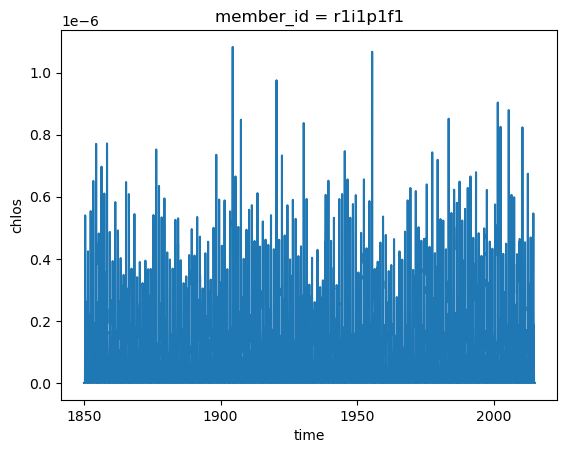

In [18]:
chlos_daily_mean.chlos.plot()

### Notes

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer

- Get daily observations

- Repeat for CESM

- Repeat for NorESM-SSP385